## Importing Relevant Packages

In [69]:
######################################################################
#                         IMPORT PACKAGES                            #
######################################################################
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import *
from matplotlib.collections import PatchCollection
from IPython.display import clear_output
import time
import random
from joblib import Parallel, delayed
import multiprocessing
import networkx as nx
import os
from collections import namedtuple,defaultdict
import itertools as it
random.seed()

## Frankenstein NetworkX Functions for Connected Closure
(to be put in its own module later)

In [70]:
from itertools import combinations, chain

from networkx.utils import pairwise
import networkx as nx

__all__ = ['metric_closure', 'steiner_tree']

def metric_closure(G, weight='weight'):
    """  Return the metric closure of a graph.

    The metric closure of a graph *G* is the complete graph in which each edge
    is weighted by the shortest path distance between the nodes in *G* .

    Parameters
    ----------
    G : NetworkX graph

    Returns
    -------
    NetworkX graph
        Metric closure of the graph `G`.

    """
    M = nx.Graph()

    Gnodes = set(G)

    # check for connected graph while processing first node
    all_paths_iter = nx.all_pairs_dijkstra(G, weight=weight)
    u, (distance, path) = next(all_paths_iter)
    if Gnodes - set(distance):
        msg = "G is not a connected graph. metric_closure is not defined."
        raise nx.NetworkXError(msg)
    Gnodes.remove(u)
    for v in Gnodes:
        M.add_edge(u, v, distance=distance[v], path=path[v])

    # first node done -- now process the rest
    for u, (distance, path) in all_paths_iter:
        Gnodes.remove(u)
        for v in Gnodes:
            M.add_edge(u, v, distance=distance[v], path=path[v])

    return M

def steiner_tree(G, terminal_nodes, weight='weight'):
    """ Return an approximation to the minimum Steiner tree of a graph.

    Parameters
    ----------
    G : NetworkX graph

    terminal_nodes : list
         A list of terminal nodes for which minimum steiner tree is
         to be found.

    Returns
    -------
    NetworkX graph
        Approximation to the minimum steiner tree of `G` induced by
        `terminal_nodes` .

    Notes
    -----
    Steiner tree can be approximated by computing the minimum spanning
    tree of the subgraph of the metric closure of the graph induced by the
    terminal nodes, where the metric closure of *G* is the complete graph in
    which each edge is weighted by the shortest path distance between the
    nodes in *G* .
    This algorithm produces a tree whose weight is within a (2 - (2 / t))
    factor of the weight of the optimal Steiner tree where *t* is number of
    terminal nodes.

    """
    # M is the subgraph of the metric closure induced by the terminal nodes of
    # G.
    M = metric_closure(G, weight=weight)
    # Use the 'distance' attribute of each edge provided by the metric closure
    # graph.
    H = M.subgraph(terminal_nodes)
    mst_edges = nx.minimum_spanning_edges(H, weight='distance', data=True)
    # Create an iterator over each edge in each shortest path; repeats are okay
    edges = chain.from_iterable(pairwise(d['path']) for u, v, d in mst_edges)
    T = G.edge_subgraph(edges)
    return T
def _ordered(u, v):
    """Returns the nodes in an undirected edge in lower-triangular order"""
    return (u, v) if u < v else (v, u)
def modded_one_edge_augmentation(subG, G, avail, weight=None):
    avail_uv, avail_w = _unpack_available_edges(avail, weight=weight, G=subG)
    # Collapse CCs in the original graph into nodes in a metagraph
    # Then find an MST of the metagraph instead of the original graph
    C = collapse(G,nx.connected_components(subG))
    mapping = C.graph['mapping']
    # Assign each available edge to an edge in the metagraph
    candidate_mapping = _lightest_meta_edges(mapping, avail_uv, avail_w)
    # nx.set_edge_attributes(C, name='weight', values=0)
    C.add_edges_from(
        (mu, mv, {'weight': w, 'generator': uv})
        for (mu, mv), uv, w in candidate_mapping
    )
    # Find MST of the meta graph
    #print(C.nodes())
    leaves = [mapping[node] for node in subG.nodes()]
    #print(leaves)
    meta_steiner = steiner_tree(C,leaves)
    #if nx.is_connected(meta_steiner):
    #    print('connected meta graph!')
    if not nx.is_connected(meta_steiner):
        raise nx.NetworkXUnfeasible(
            'Not possible to connect G with available edges')
    # Yield the edge that generated the meta-edge
    for mu, mv, d in meta_steiner.edges(data=True):
        if 'generator' in d:
            #print('doublechecked')
            edge = d['generator']
            yield edge

def connect_graph(subG,G,avail,weight=None):
    aug_edges = modded_one_edge_augmentation(subG,G,avail,weight=weight)
    for edge in list(aug_edges):
        yield edge
        
def _unpack_available_edges(avail, weight=None, G=None):
    """Helper to separate avail into edges and corresponding weights"""
    if weight is None:
        weight = 'weight'
    if isinstance(avail, dict):
        avail_uv = list(avail.keys())
        avail_w = list(avail.values())
    else:
        def _try_getitem(d):
            try:
                return d[weight]
            except TypeError:
                return d
        avail_uv = [tup[0:2] for tup in avail]
        avail_w = [1 if len(tup) == 2 else _try_getitem(tup[-1])
                   for tup in avail]

    if G is not None:
        # Edges already in the graph are filtered
        flags = [not G.has_edge(u, v) for u, v in avail_uv]
        avail_uv = list(it.compress(avail_uv, flags))
        avail_w = list(it.compress(avail_w, flags))
    return avail_uv, avail_w

def collapse(G, grouped_nodes):
    """Collapses each group of nodes into a single node.

    This is similar to condensation, but works on undirected graphs.

    Parameters
    ----------
    G : NetworkX Graph

    grouped_nodes:  list or generator
       Grouping of nodes to collapse. The grouping must be disjoint.
       If grouped_nodes are strongly_connected_components then this is
       equivalent to :func:`condensation`.

    Returns
    -------
    C : NetworkX Graph
       The collapsed graph C of G with respect to the node grouping.  The node
       labels are integers corresponding to the index of the component in the
       list of grouped_nodes.  C has a graph attribute named 'mapping' with a
       dictionary mapping the original nodes to the nodes in C to which they
       belong.  Each node in C also has a node attribute 'members' with the set
       of original nodes in G that form the group that the node in C
       represents.

    Examples
    --------
    >>> # Collapses a graph using disjoint groups, but not necesarilly connected
    >>> G = nx.Graph([(1, 0), (2, 3), (3, 1), (3, 4), (4, 5), (5, 6), (5, 7)])
    >>> G.add_node('A')
    >>> grouped_nodes = [{0, 1, 2, 3}, {5, 6, 7}]
    >>> C = collapse(G, grouped_nodes)
    >>> members = nx.get_node_attributes(C, 'members')
    >>> sorted(members.keys())
    [0, 1, 2, 3]
    >>> member_values = set(map(frozenset, members.values()))
    >>> assert {0, 1, 2, 3} in member_values
    >>> assert {4} in member_values
    >>> assert {5, 6, 7} in member_values
    >>> assert {'A'} in member_values
    """
    mapping = {}
    members = {}
    C = G.__class__()
    i = 0  # required if G is empty
    remaining = set(G.nodes())
    for i, group in enumerate(grouped_nodes):
        group = set(group)
        assert remaining.issuperset(group), (
            'grouped nodes must exist in G and be disjoint')
        remaining.difference_update(group)
        members[i] = group
        mapping.update((n, i) for n in group)
    # remaining nodes are in their own group
    for i, node in enumerate(remaining, start=i + 1):
        group = set([node])
        members[i] = group
        mapping.update((n, i) for n in group)
    number_of_groups = i + 1
    C.add_nodes_from(range(number_of_groups))
    C.add_edges_from((mapping[u], mapping[v]) for u, v in G.edges()
                     if mapping[u] != mapping[v])
    # Add a list of members (ie original nodes) to each node (ie scc) in C.
    nx.set_node_attributes(C, name='members', values=members)
    # Add mapping dict as graph attribute
    C.graph['mapping'] = mapping
    return C


MetaEdge = namedtuple('MetaEdge', ('meta_uv', 'uv', 'w'))

def _lightest_meta_edges(mapping, avail_uv, avail_w):
    """Maps available edges in the original graph to edges in the metagraph.

    Parameters
    ----------
    mapping : dict
        mapping produced by :func:`collapse`, that maps each node in the
        original graph to a node in the meta graph

    avail_uv : list
        list of edges

    avail_w : list
        list of edge weights

    Notes
    -----
    Each node in the metagraph is a k-edge-connected component in the original
    graph.  We don't care about any edge within the same k-edge-connected
    component, so we ignore self edges.  We also are only intereseted in the
    minimum weight edge bridging each k-edge-connected component so, we group
    the edges by meta-edge and take the lightest in each group.

    Example
    -------
    >>> # Each group represents a meta-node
    >>> groups = ([1, 2, 3], [4, 5], [6])
    >>> mapping = {n: meta_n for meta_n, ns in enumerate(groups) for n in ns}
    >>> avail_uv = [(1, 2), (3, 6), (1, 4), (5, 2), (6, 1), (2, 6), (3, 1)]
    >>> avail_w =  [    20,     99,     20,     15,     50,     99,     20]
    >>> sorted(_lightest_meta_edges(mapping, avail_uv, avail_w))
    [MetaEdge(meta_uv=(0, 1), uv=(5, 2), w=15), MetaEdge(meta_uv=(0, 2), uv=(6, 1), w=50)]
    """
    grouped_wuv = defaultdict(list)
    for w, (u, v) in zip(avail_w, avail_uv):
        # Order the meta-edge so it can be used as a dict key
        meta_uv = _ordered(mapping[u], mapping[v])
        # Group each available edge using the meta-edge as a key
        grouped_wuv[meta_uv].append((w, u, v))

    # Now that all available edges are grouped, choose one per group
    for (mu, mv), choices_wuv in grouped_wuv.items():
        # Ignore available edges within the same meta-node
        if mu != mv:
            # Choose the lightest available edge belonging to each meta-edge
            w, u, v = min(choices_wuv)
            yield MetaEdge((mu, mv), (u, v), w)

## Computing Visibility and Connectivity Graphs
Uses a new "nondeterministic selection" method to compute the visibility graph in comparable time to parallelization.  Will speed up in future work

In [88]:
######################################################################
#                     PARAMETERS AND FUNCTIONS                       #
######################################################################

# Calculates if points s and t are visibile to each other
def Cvis(pt1,pt2):
    s = pt1
    t = pt2
    result = Or([And((Or(O[i][0] == s[0],(bool(np.sign(t[0]-O[i][0]+np.sign(O[i][0]-s[0])) == np.sign(O[i][0]-s[0]))))),
                        Or(O[i][1] == s[1],(bool(np.sign(t[1]-O[i][1]+np.sign(O[i][1]-s[1])) == np.sign(O[i][1]-s[1])))))
                        for i in range(numobjects)])
    return is_true(simplify(Not(result)))

#OUTPUT PREFERENCES
makeplots = True
logicalsoutput = False
modeltoterminal = False
randomobjects = False
modeltxt = False
mapchoice = 'GT'
parallel = False
nondet = True


#ALLOWANCE REFERENCES:
# UCLA MAP: 1 Meter ~ 2.2 pixels
# USC MAP: 1 Meter ~ 1.82 pixels
# ARL MAP: 1 Meter ~ 1.53 pixels
sensing_radius = 80#float('inf') #distance each camera can see, in pixels on image
connectivity_radius = 120

if mapchoice == 'UCLA':
    UCLAmap = True
    USCmap = False
    ARLmap = False
    GTmap = False
    manualmap = False
    xgrid = 33
    ygrid = 25
    numobjects = 378
elif mapchoice == 'USC':
    UCLAmap = False
    USCmap = True
    ARLmap = False
    GTmap = False
    manualmap = False
    xgrid = 26
    ygrid = 21
    numobjects = 175
elif mapchoice == 'ARL':
    UCLAmap = False
    USCmap = False
    ARLmap = True
    GTmap = False
    manualmap = False
    xgrid = 31
    ygrid = 27
    numobjects = 246
elif mapchoice == 'GT': #may be a tad bit too large, consider cutting down
    UCLAmap = False
    USCmap = False
    ARLmap = False
    GTmap = True
    manualmap = False
    xgrid = 50
    ygrid = 51
    numobjects = 815
elif mapchoice == 'manual':
    UCLAmap = False
    USCmap = False
    ARLmap = False
    GTmap = False
    manualmap = True
    xgrid = 10
    ygrid = 10
    numobjects = 10

#Boolean grid, True where cameras are to be placed C[xpos][ypos] = T/F
C = [[Bool('C[%s][%s]' % (j,i)) for i in range(ygrid)] for j in range(xgrid)]

#OBJECT LOCATION IN GRID O[objectnumber][x=index 0, y = index 1]
O = [[Int('Obj%s_x' % i ), Int('Obj%s_y' % i)] for i in range(1,numobjects+1)]
#O = [[1,1]]


######################################################################
#                     DISTANCE CONSIDERATIONS                        #
######################################################################

#Edge weighting in each direction Costs[xpos][ypos] = [width, height]
#Costs = np.ones((xgrid,ygrid,2))
precalcstart = time.time()

#This chunk imports edge weights from UCLA map segment and formats them appropriately
Costs = np.empty((xgrid,ygrid,2))
if UCLAmap == True:
    xcosts = open('UCLAmapxcosts.txt',mode='r')
    ycosts = open('UCLAmapycosts.txt',mode='r')
elif USCmap == True:
    xcosts = open('USCmapxcosts.txt',mode='r')
    ycosts = open('USCmapycosts.txt',mode='r')
elif ARLmap == True:
    xcosts = open('ARLmapxcosts.txt',mode='r')
    ycosts = open('ARLmapycosts.txt',mode='r')
elif GTmap == True:
    xcosts = open('GTmapxcosts.txt',mode='r')
    ycosts = open('GTmapycosts.txt',mode='r')
if manualmap == False:
    x = 0
    xvals = xcosts.readlines()
    yvals = ycosts.readlines()
    for i in xvals:
        y = 0
        xc = i.replace("\n","")
        for j in yvals:
            yc = j.replace("\n","")
            Costs[x,y,0] = float(xc)
            Costs[x,y,1] = float(yc)
            y += 1
        x += 1
    xcosts.close()
    ycosts.close()
elif manualmap == True:
    Costs = np.ones((xgrid,ygrid,2))

#this chunk imports object locations from UCLA map segment
objlocs = 0
if UCLAmap == True:
    randomobjects = False
    objlocs = open('UCLAmapobjects.txt',mode='r')
elif USCmap == True:
    randomobjects = False
    objlocs = open('USCmapobjects.txt',mode='r')
elif ARLmap == True:
    randomobjects = False
    objlocs = open('ARLmapobjects.txt',mode='r')
elif GTmap == True:
    randomobjects = False
    objlocs = open('GTmapobjects.txt',mode='r')
locs = []
if not(objlocs == 0):
    for i in objlocs:
        loc = i.replace("\n","")
        loc = loc.split(",")
        locs.append(loc)
    locs = [[int(i[0]), int(i[1])] for i in locs]
    objlocs.close()
    O = locs

    
vis = [[set() for i in range(ygrid)] for j in range(xgrid)]

locations = [] #generate list of all potential object locations (gridspace - object locations)
for i in range(xgrid):
	for j in range(ygrid):
		locations.append((i, j))
for o in range(numobjects): #select random option from list (if desired)
	if randomobjects == True:
		O[o] = random.choice(locations)
	locations.remove((O[o][0],O[o][1]))	#remove selected option from list (no sensors on objects, no doubly placed objects)

conn_graph = nx.Graph()
conn_graph.add_nodes_from(locations)
    
Dists = np.ones([xgrid,ygrid,xgrid,ygrid])*np.inf #Start distances at infinity (so objects are not 'seeable')
for pt1 in range(len(locations)):
    for pt2 in range(pt1,len(locations)):
        x = sum(Costs[min(locations[pt1][0],locations[pt2][0]):max(locations[pt1][0],locations[pt2][0])+1,locations[pt1][1],0])
        y = sum(Costs[locations[pt1][0],min(locations[pt1][1],locations[pt2][1]):max(locations[pt1][1],locations[pt2][1])+1,1])
        maxdist = np.sqrt(x**2 + y**2)
        Dists[locations[pt1][0],locations[pt1][1],locations[pt2][0],locations[pt2][1]] = maxdist
        Dists[locations[pt2][0],locations[pt2][1],locations[pt1][0],locations[pt1][1]] = maxdist #Abuse symmetry
        if (maxdist <= sensing_radius):
            vis[locations[pt1][0]][locations[pt1][1]].add(locations[pt2])
        if (maxdist <= connectivity_radius) and (pt1 != pt2):
            conn_graph.add_edge(locations[pt1],locations[pt2])


vis_graph = nx.Graph()
vis_graph.add_nodes_from(locations)
if nondet == True:
    count = 0
    nondettimes = time.time()
    for u1 in locations:
        #print('initial, point',u1,':',vis[u1[0]][u1[1]])
        while any(vis[u1[0]][u1[1]]) :
            u2 = random.choice(tuple(vis[u1[0]][u1[1]]))
            #print('choice:',u2)
            if Cvis(u1,u2):
                #Generates square of spaces with u1 and u2 at corners
                conv = {(x,y) for y in range(min(u1[1],u2[1]),max(u1[1],u2[1])+1) 
                                for x in range(min(u1[0],u2[0]),max(u1[0],u2[0])+1)}
                #vis[u1[0]][u1[1]] = [x for x in vis[u1[0]][u1[1]] if x not in conv]
                #print('conv:',conv)
                #print('vis:',vis[u1[0]][u1[1]])
                vis[u1[0]][u1[1]].difference_update(conv)
                for e1 in conv:
                    for e2 in conv:
                        vis_graph.add_edge(e1,e2)
                        vis[e1[0]][e1[1]].discard(e2)
            else :
                vis[u1[0]][u1[1]].remove(u2)
        count+=1
        #print('pass',count,'complete')
        clear_output(wait=True)
        print('%d %% calculated' % (count/len(locations)*100))
    print('New time:',time.time()-nondettimes)
else :
    ######################################################################
    #                    GENERATE VISIBLE SETS                           #
    ######################################################################
    # Pull only the points that are within allow of each other
    vis = np.transpose(np.nonzero(Dists <= sensing_radius))
    vis = vis.tolist()
    for el in vis:
        if [el[0],el[1]] == [el[2],el[3]]:
            continue
        else :
            vis.remove([el[2],el[3],el[0],el[1]]) #Abuse symmetry


    # can be done in parallel if desired
    if parallel == True:
        start = time.time()
        num_cores = multiprocessing.cpu_count()
        results = Parallel(n_jobs=num_cores)(delayed(Cvis)((i[0],i[1]),(i[2],i[3])) for i in vis)
        #print('Parallel compute time:',np.floor((time.time() - start)/60) ,'minutes', (time.time() - start)%60 ,'seconds')
        for i, pt in enumerate(vis):
            pt1 = (pt[0],pt[1])
            pt2 = (pt[2],pt[3])
            if results[i]:
                vis_graph.add_edge(pt1,pt2)
    else:
        for pt in vis:
            if Cvis((pt[0],pt[1]),(pt[2],pt[3])):
                vis_graph.add_edge((pt[0],pt[1]),(pt[2],pt[3]))

# Output the precalculation/prep time for benchmark purposes
precalctime = time.time() - precalcstart
print('PRECALCULATION COMPLETED')
print('Total precalculation time:', np.floor(precalctime/60),'minutes', precalctime%60,'seconds')

100 % calculated
New time: 2728.8173928260803
PRECALCULATION COMPLETED
Total precalculation time: 45.0 minutes 56.40524625778198 seconds


## Feasibility Checks
Can be used to check if there are any isolated nodes in visibility graph (coverage impossible).
Can checks if full connectivity graph is not connected (connectivity impossible)

In [89]:
isolates = list(nx.isolates(vis_graph))
connectivity_reachable = nx.is_connected(conn_graph)
if isolates or not connectivity_reachable:
    print('Infeasible setup!')
    if isolates:
        print('Un-coverable regions:')
        print(isolates)
    if not connectivity_reachable:
        print('No connected subgraph exists.')

## SAT and Closure Implementation
Initially uses SAT to compute a solution to the coverage problem.
If solution is not connected, follows this by collapsing subgraph of connectivity graph induced by SAT solution and computing steiner tree problem apprximation.  Then maps result back to initial space and adds necessary nodes, reporting number required to connect.

In [ ]:
######################################################################
#                     CONSTRAINT GENERATION                          #
######################################################################
constrstart = time.time()

numcams = 122#number of cameras to be used
coverlevel = 1 #number of cameras to cover each block

# Create a list of visibility constraints
# At each point (x,y), select at least coverlevel locations that are visible to (x,y)
visibility = []
for node in locations:
    visibility.append(Sum([If(C[nbr[0]][nbr[1]],1,0) for nbr in vis_graph.adj[node]]) >= coverlevel)

# Limit the number of squares that can be True -- only use numcams cameras
camnumconstr = []
camnumconstr.append(Sum([If(C[pt[0]][pt[1]],1,0) for pt in locations]) == numcams)

# At least contain only connected sub-components                          
connectivity = []
for pt1 in locations:
    #connectivity.append(Sum([If(C[pt2[0]][pt2[1]],1,0) for pt2 in halfconn_graph[pt1[0]][pt1[1]]]) >= 1)
    connectivity.append(Implies(C[pt1[0]][pt1[1]],Or([C[pt2[0]][pt2[1]] for pt2 in conn_graph[pt1[0],pt1[1]]])))                           
                           
# Do not select object locations to be camera locations
notobject = []
for o in range(numobjects):
    notobject.append(C[O[o][0]][O[o][1]] == False)

addlconstr = []    
#EXAMPLE EXTRA CONSTRAINT:
#UCLA MAP - Cover central courtyard extra well
#for i in range(15,18):
#    for j in range(3,21):
#        addlconstr.append(Sum([If(C[pt2[0]][pt2[1]],1,0) for pt2 in l[i][j]]) >= coverlevel+1)

#EXAMPLE EXTRA CONSTRAINT:
#ARL MAP - Don't put sensors in 

# Output time generating constraints for benchmarking purposes
constrainttime = time.time() - constrstart
print('Constraint calculation time:', np.floor(constrainttime/60), 'm', constrainttime%60, 's')

######################################################################
#                          RUNNING SOLVER                            #
######################################################################
s = Solver()

solverstart = time.time()
s.add(visibility)
s.add(camnumconstr)
s.add(notobject)
#s.add(connectivity)

if addlconstr:
    s.add(addlconstr)
satcheck = s.check()
solvertime = time.time() - solverstart
connectionstart = time.time()
connected = False
added_nodes = 0
if satcheck == sat:
    m = s.model()
    #create list of locations
    sol = []
    for pt in locations:
        if m.evaluate(C[pt[0]][pt[1]]):
            sol.append(tuple(pt))
    sol_graph = conn_graph.subgraph(sol)
    connected = nx.is_connected(sol_graph)
    original_number_nodes = sol_graph.order()
    if connected :
        final_graph = sol_graph
    if not connected :
        avail = set(conn_graph.edges()).difference(set(sol_graph.edges()))
        aug_edges = connect_graph(sol_graph,conn_graph,avail)
        to_add = list(sol_graph.edges())+list(aug_edges)
        final_graph = conn_graph.edge_subgraph(to_add)
        added_nodes = final_graph.order() - original_number_nodes
        connected = nx.is_connected(final_graph)

connectiontime = time.time() - connectionstart
        
print('Solver runtime :', np.floor(solvertime/60), 'm', solvertime%60,'s')
print('Connection algorithm runtime :', np.floor(connectiontime/60), 'm', connectiontime%60,'s')
print('Total elapsed time :', np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
print('SOLVER STATUS:',satcheck)
print('CONNECTED STATUS:', connected,', after adding',added_nodes,'nodes')

Constraint calculation time: 0.0 m 20.327258825302124 s


## Visualization
Generates "before" and "after" plots for SAT result and fully connected result (if connection step necessary.)
Plots nodes in red, with lines drawn between nodes if they are within connectivity radius of each other.
Plots "added" nodes for connectivity slightly larger, in blue.
Underset heatmap displays level of coverage at each point in discrete space.
(Sizing of some plot points may need to be adjusted for a nice image.)


		PROBLEM: SATISFIABLE				    
Map: UCLA
Number of cameras: 128
Cover level: 1
Added nodes: 6
Total computation time : 2.0 m 3.823176622390747 s
Pre-calculation time: 1.0 m 59.087032079696655 s
Constraint generation : 0.0 m 1.137953758239746 s
Solver runtime : 0.0 m 3.5981907844543457 s


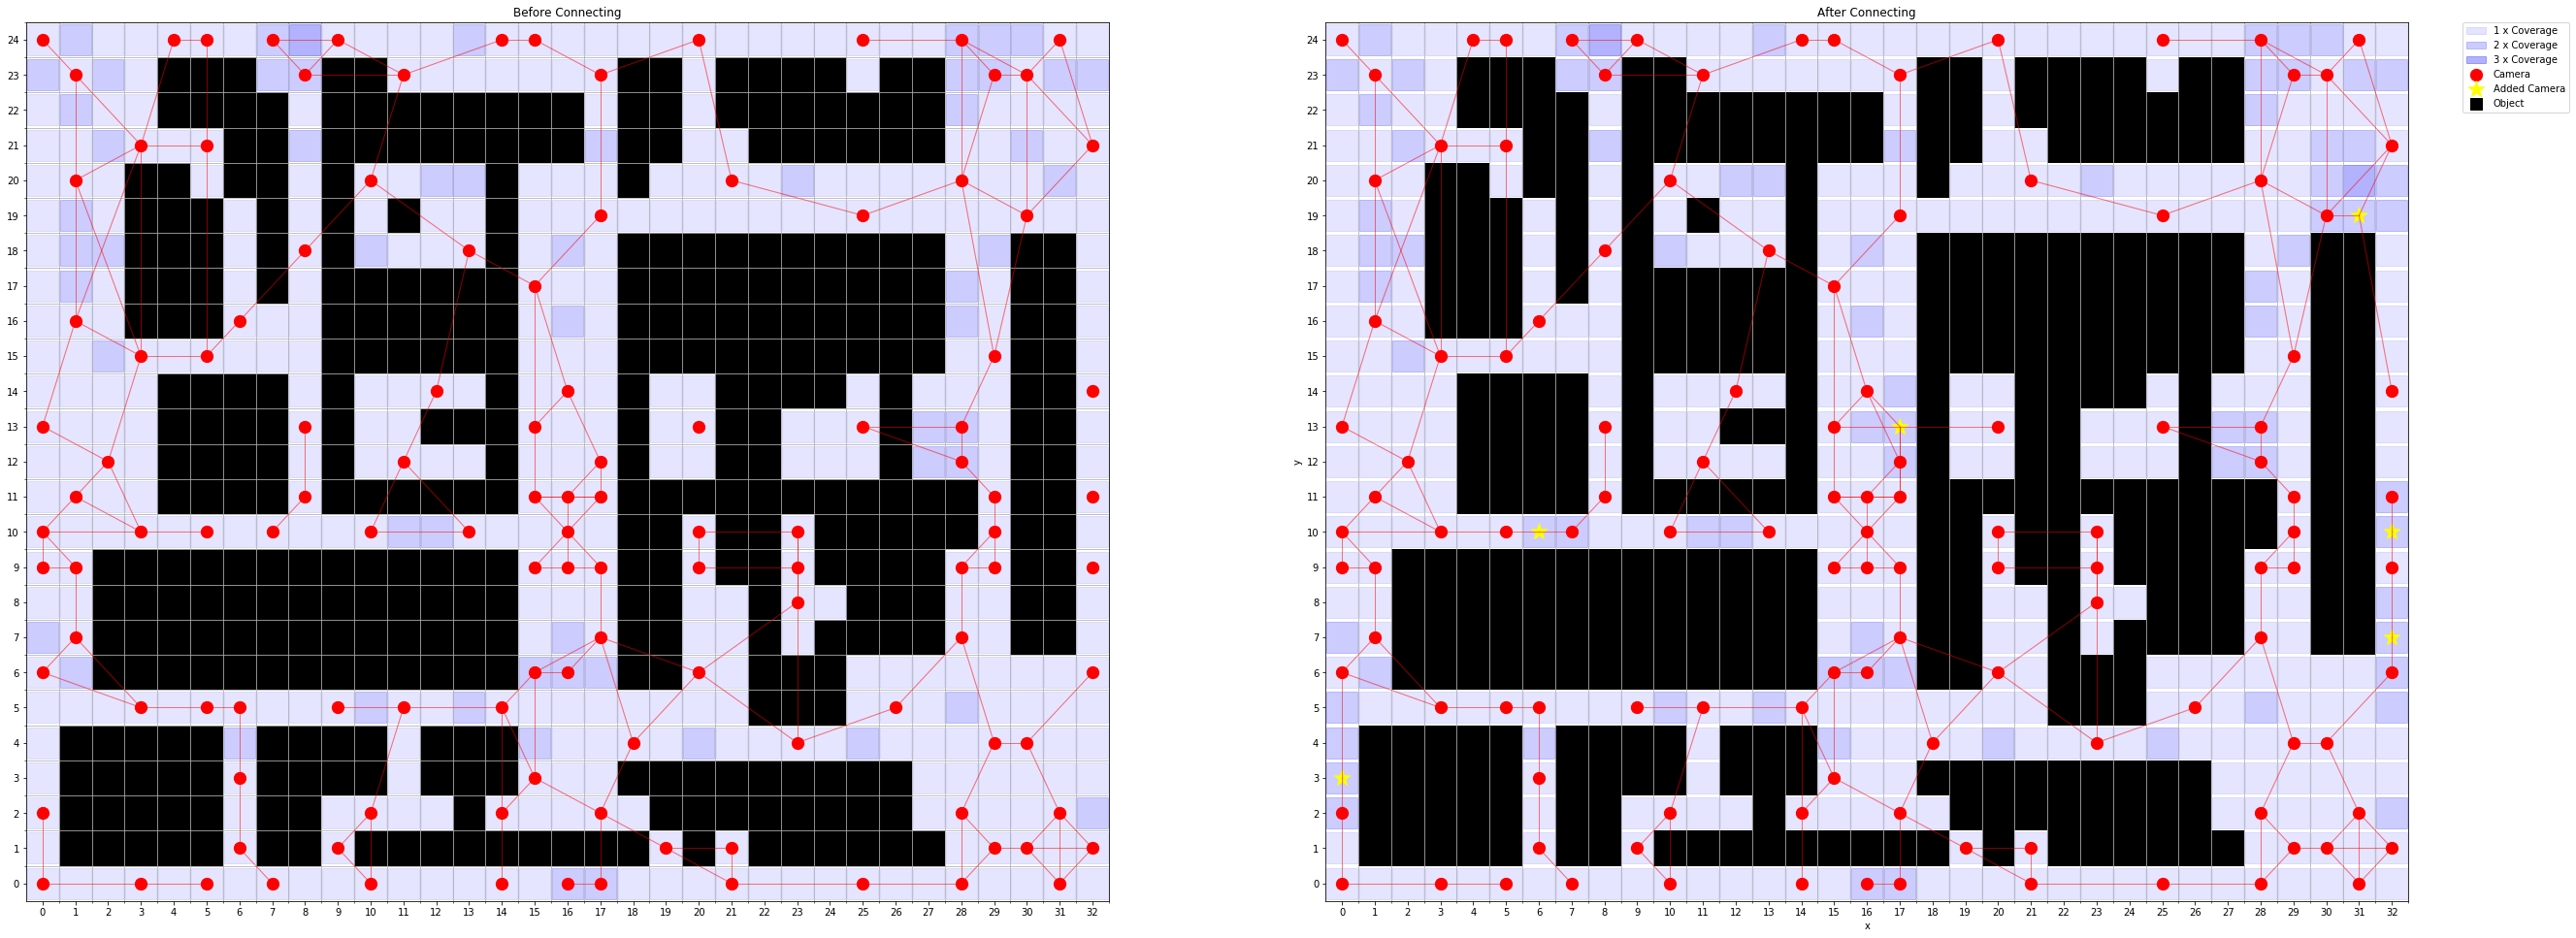

In [122]:
if satcheck == sat:
	#m = s.model()
	#model = ['%s = %s' % (d.name(), m[d]) for d in m.decls()]
	#model.sort()
	print ('\n=======================================================')
	print ('		PROBLEM: SATISFIABLE				    ')
	print ('=======================================================')
	print ('Map:', mapchoice)
	print ('Number of cameras:', numcams+added_nodes)
	print ('Cover level:', coverlevel)
	print ('Added nodes:', added_nodes)
	print ('Total computation time :',np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
	print ('Pre-calculation time:', np.floor(precalctime/60),'m',precalctime%60,'s')
	print ('Constraint generation :', np.floor(constrainttime/60), 'm', constrainttime%60, 's')
	print('Solver runtime :', np.floor(solvertime/60), 'm', solvertime%60,'s')
else:
	print('\n=======================================================')
	print('		PROBLEM: INFEASIBLE				    ')
	print('=======================================================')
	print ('Map:', mapchoice)
	print ('Number of cameras:', numcams)
	print ('Cover level:', coverlevel)
	print('Total computation time :',np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
	print('Pre-calculation time:', np.floor(precalctime/60),'m',precalctime%60,'s')
	print('Constraint generation :', np.floor(constrainttime/60), 'm', constrainttime%60, 's')

if satcheck == sat and added_nodes != 0:
    scale = 1.5
	#parses model strings for camera locations, works because of alphabetized variable names...
    initcams = list(sol_graph.nodes())
    finalcams = list(final_graph.nodes())
    datamap = plt.figure(figsize=(2*xgrid/scale,ygrid/scale))
    #create subplot layer for objects and gridlines
    ax1 = datamap.add_subplot(121)
    ax2 = datamap.add_subplot(122)
    #Set x and y axis markers
    xaxis = range(0,xgrid)
    yaxis = range(0,ygrid)
    ax1.set_xticks(xaxis)
    ax1.set_yticks(yaxis)
    ax2.set_xticks(xaxis)
    ax2.set_yticks(yaxis)

    #plot squares where objects are
    #creates list of squares with one for each object
    obstacles = []

    for i in range(numobjects):
        objmap = patches.Rectangle((O[i][0]-0.5,O[i][1]-0.5), 1, 1)
        obstacles.append(objmap)
    obstaclesquares1 = PatchCollection(obstacles, facecolor = 'black', label = 'Object')
    obstaclesquares2 = PatchCollection(obstacles, facecolor = 'black', label = 'Object')
    ax1.add_collection(obstaclesquares1)
    ax2.add_collection(obstaclesquares2)
    #set plot limits so all of the boxes are visible
    ax1.set_ylim([-0.5,ygrid-0.5])
    ax1.set_xlim([-0.5,xgrid-0.5])
    ax2.set_ylim([-0.5,ygrid-0.5])
    ax2.set_xlim([-0.5,xgrid-0.5])

    textsize = 100
    initheatmap = np.zeros((xgrid,ygrid))
    finalheatmap = np.zeros((xgrid,ygrid))
    alphaval = 0.1
    if satcheck == sat:
        InitCamlocs = np.array(initcams)
        FinalCamlocs = np.array(finalcams)
        for loc in InitCamlocs:
            for el in vis_graph[(loc[0],loc[1])]:
                initheatmap[el[0],el[1]] += 1
        newnodes = set(final_graph.nodes()).difference(sol_graph.nodes())
        newnodes = np.array(list(newnodes))
        for loc in FinalCamlocs:
            for el in vis_graph[(loc[0],loc[1])]:
                finalheatmap[el[0],el[1]] += 1
        if alphaval*np.max(initheatmap) > 1:
            alphaval = 1.0/np.max(initheatmap)
        if alphaval*np.max(finalheatmap) > 1:
            alphaval = 1.0/np.max(finalheatmap)
        for loc in locations:
            ax1.scatter(loc[0],loc[1], c = 'blue', marker = 's', s = 1000, alpha = initheatmap[loc[0],loc[1]]*alphaval)
            ax2.scatter(loc[0],loc[1], c = 'blue', marker = 's', s = 1000, alpha = finalheatmap[loc[0],loc[1]]*alphaval)
            #plt.scatter(C[i][0],C[i][1], marker = '$C%s$' % (i+1), s = textsize)
        initcamplots = ax1.scatter(InitCamlocs[:,0],InitCamlocs[:,1], c = 'red', marker = 'o',s=150, label='Camera')
        ax2.scatter(InitCamlocs[:,0],InitCamlocs[:,1], c = 'red', marker = 'o',s=150, label='Camera')
        addedcamplots = ax2.scatter(newnodes[:,0],newnodes[:,1], c = 'blue', marker = 'o', s = 200, label='Added Camera')

    #plot where the objects are with white O#'s on top of the black square
    #for i in range(numobjects):
    Objlocs = np.array(O)
    objplots = ax1.scatter(Objlocs[:,0],Objlocs[:,1], marker = 's', s = 150, color = 'black', label='Object')
    ax2.scatter(Objlocs[:,0],Objlocs[:,1], marker = 's', s = 150, color = 'black', label='Object')
    for i,cam1 in enumerate(InitCamlocs):
            for j,cam2 in enumerate(InitCamlocs):
                if ((cam2[0],cam2[1]) in conn_graph[cam1[0],cam1[1]]) :
                    ax1.plot([InitCamlocs[i,0],InitCamlocs[j,0]],[InitCamlocs[i,1],InitCamlocs[j,1]],c='red',linewidth=1,alpha=0.3)
    for i,cam1 in enumerate(FinalCamlocs):
            for j,cam2 in enumerate(FinalCamlocs):
                if ((cam2[0],cam2[1]) in conn_graph[cam1[0],cam1[1]]) :
                    ax2.plot([FinalCamlocs[i,0],FinalCamlocs[j,0]],[FinalCamlocs[i,1],FinalCamlocs[j,1]],c='red',linewidth=1,alpha=0.3)

    handlelist = []
    for i in range(int(np.max(initheatmap))):
        handlelist += [patches.Patch(color='blue',alpha=(i+1)*alphaval,label=('%s x Coverage' % (i+1)))]
    handlelist += [initcamplots]
    handlelist += [addedcamplots]
    handlelist += [objplots]
    #create gridlines in the correct locations
    minor_locatorx = AutoMinorLocator(2)
    minor_locatory = AutoMinorLocator(2)
    ax1.xaxis.set_minor_locator(minor_locatorx)
    ax1.yaxis.set_minor_locator(minor_locatory)
    ax2.xaxis.set_minor_locator(minor_locatorx)
    ax2.xaxis.set_minor_locator(minor_locatory)
    ax1.grid(which='minor')
    ax2.grid(which='minor')
    ax1.title.set_text('Before Connecting')
    ax2.title.set_text('After Connecting')
    plt.xlabel('x')
    plt.ylabel('y')
    ax1.legend(handles=handlelist,bbox_to_anchor=(2.25, 1), loc=2, borderaxespad=0.)
    plt.savefig('Comparison.png')
    plt.show()


else:    
    cams = list(final_graph.nodes())
    scale = 2
    #create plot object
    datamap = plt.figure(figsize=(xgrid/scale,ygrid/scale))
    #create subplot layer for objects and gridlines
    ax = datamap.add_subplot(111)

    #Set x and y axis markers
    xaxis = range(0,xgrid)
    yaxis = range(0,ygrid)
    plt.xticks(xaxis)
    plt.yticks(yaxis)

    #plot squares where objects are
    #creates list of squares with one for each object
    obstacles = []

    for i in range(numobjects):
        objmap = patches.Rectangle((O[i][0]-0.5,O[i][1]-0.5), 1, 1)
        obstacles.append(objmap)
    obstaclesquares = PatchCollection(obstacles, facecolor = 'black', label = 'Object')
    ax.add_collection(obstaclesquares)

    #set plot limits so all of the boxes are visible
    plt.ylim(-0.5,ygrid-0.5)
    plt.xlim(-0.5,xgrid-0.5)

    textsize = 100
    heatmap = np.zeros((xgrid,ygrid))
    alphaval = 0.1
    if satcheck == sat:
        Camlocs = np.array(cams)
        for loc in Camlocs:
            for el in vis_graph[(loc[0],loc[1])]:
                heatmap[el[0],el[1]] += 1
        if alphaval*np.max(heatmap) > 1:
            alphaval = 1.0/np.max(heatmap)
        for loc in locations:
            ax.scatter(loc[0],loc[1], c = 'blue', marker = 's', s = 740, alpha = heatmap[loc[0],loc[1]]*alphaval)
            #plt.scatter(C[i][0],C[i][1], marker = '$C%s$' % (i+1), s = textsize)
        camplots = ax.scatter(Camlocs[:,0],Camlocs[:,1], c = 'red', marker = 'o',s=150, label='Camera')



    #plot where the objects are with white O#'s on top of the black square
    #for i in range(numobjects):
    Objlocs = np.array(O)
    objplots = ax.scatter(Objlocs[:,0],Objlocs[:,1], marker = 's', s = 150, color = 'black', label='Object')

    for i,cam1 in enumerate(Camlocs):
            for j,cam2 in enumerate(Camlocs):
                if ((cam2[0],cam2[1]) in conn_graph[cam1[0],cam1[1]]) :
                    ax.plot([Camlocs[i,0],Camlocs[j,0]],[Camlocs[i,1],Camlocs[j,1]],c='red',linewidth=1,alpha=0.3)

    handlelist = []
    for i in range(int(np.max(heatmap))):
        handlelist += [patches.Patch(color='blue',alpha=(i+1)*alphaval,label=('%s x Coverage' % (i+1)))]
    handlelist += [camplots]
    handlelist += [objplots]
    #create gridlines in the correct locations
    minor_locatorx = AutoMinorLocator(2)
    minor_locatory = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locatorx)
    ax.yaxis.set_minor_locator(minor_locatory)
    plt.grid(which='minor')
    plt.xlabel('x')
    plt.ylabel('y')
    ax.legend(handles=handlelist,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    #plt.tight_layout()
    if GTmap == True:
        plt.savefig('GTDiscreteResult.png')
    elif UCLAmap == True:
        plt.savefig('UCLADiscreteResult.png')
    elif USCmap == True:
        plt.savefig('USCDiscreteResult.png')
    elif ARLmap == True:
        plt.savefig('ARLDiscreteResult.png')
    plt.show()